**Please use Python or R to answer this question. Use the attachment icon in the tools menu to upload your response. If possible, please upload a single file containing your code and written answers, like a Jupyter notebook with markdown cells, or an R markdown file, or a PDF or HTML file. It is also acceptable to upload your code or notebook as a standalone file and to submit your written answers in the free text response space or as a separate upload. If you do provide your Python or R notebook or file, please also include a PDF of the file as well.**

In order to improve user retention and lower churn, the growth team at Robinhood is interested in understanding why and which users withdraw money from their Robinhood account. A user is considered churned when their equity value (amount of money in Robinhood account) falls below $10 for a period of 28 consecutive calendar days or longer after having previously been at least $10.

Using the datasets given below, answer the following questions:

a) What percentage of users have churned in the data provided? [4 points]

b) Build a classifier that, given a user with their features, assigns a churn probability for every user and predicts which users will churn. How well does your classifier perform? State any metrics you deem important here. Based on the classifier output, classify each user in the dataset as churned or not churned. [5 points]

c) List the most important features that correlate to user churn. [3 points]

Please provide the code and any explanation of your assumptions and methodology.

In [843]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier,  Pool
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn import svm

In [844]:
# read the churn data 
evd_df = pd.read_csv(r"C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind-assignments\Churn project\data\equity_value_data.csv")
evd_df.shape


(1119158, 3)

In [845]:
df = pd.read_csv(r"C:\Users\BalintStewart\OneDrive - Health Data Research\Desktop\magnimind-assignments\Churn project\data\features_data.csv")
df.shape

(5584, 9)

In [846]:
# number of unique customers
evd_df.user_id.nunique()

5584

Number of unique customers in equity data matches number of rows in feature data which is good!

In [847]:
evd_df.head()

,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [848]:
evd_df.dtypes

timestamp        object
close_equity    float64
user_id          object
dtype: object

In [849]:
# Make sure all equity values are 10 or above
evd_df[evd_df['close_equity'] < 10].shape[0]

0

In [850]:
# sort values by user and timestamp
evd_df = evd_df.sort_values(['user_id','timestamp'])

In [851]:
# Check timeperiod of the data is as expected (2016-08-16, and 2017-08-18) 
evd_df['timestamp'].describe() 

count                  1119158
unique                     255
top       2017-03-09T00:00:00Z
freq                      5274
Name: timestamp, dtype: object

In [852]:
evd_df['timestamp'] = pd.to_datetime(evd_df['timestamp'])

In [853]:
# For each user, look for time deltas >28 days (time periods where user had <$10 close equity).
evd_df['time_delta'] = evd_df.groupby('user_id')['timestamp'].diff()
evd_df['delta_days'] = evd_df['time_delta'].dt.days

In [854]:
evd_df.isna().sum()

timestamp          0
close_equity       0
user_id            0
time_delta      5584
delta_days      5584
dtype: int64

In [855]:
evd_df.head()

,timestamp,close_equity,user_id,time_delta,delta_days
505994,2016-08-18 00:00:00+00:00,1211.6055,0012db34aa7b083f5714e7831195e54d,NaT,NaN
505995,2016-08-19 00:00:00+00:00,1173.5640,0012db34aa7b083f5714e7831195e54d,1 days,1.0
505996,2016-08-22 00:00:00+00:00,1253.0597,0012db34aa7b083f5714e7831195e54d,3 days,3.0
505997,2016-08-23 00:00:00+00:00,1252.9050,0012db34aa7b083f5714e7831195e54d,1 days,1.0
505998,2016-08-24 00:00:00+00:00,1262.1360,0012db34aa7b083f5714e7831195e54d,1 days,1.0


In [856]:
# Identify customers who disappear for >28days (and come back again)
evd_df['is_churn_return'] = np.where(evd_df['delta_days'] >= 28, 1, 0)

In [857]:
churned_return = evd_df.loc[evd_df['is_churn_return'] == 1]
churned_returned_df = pd.DataFrame({'user_id':churned_return['user_id'].unique()})

In [858]:
churned_returned = evd_df[evd_df['user_id'].isin(churned_returned_df['user_id'])]

In [859]:
churned_returned.sample(10)

,timestamp,close_equity,user_id,time_delta,delta_days,is_churn_return
106424,2017-05-23 00:00:00+00:00,868.7300,9121bbdb811bcb10de9b6f85b2b5e458,1 days,1.0,0
565254,2017-07-10 00:00:00+00:00,135.9200,224a5a89d852aa75396853e5ea66c6cc,3 days,3.0,0
558465,2017-02-27 00:00:00+00:00,224.9095,06d8d807c4752e58a570eb1f0eb45457,3 days,3.0,0
558525,2017-05-23 00:00:00+00:00,440.7438,06d8d807c4752e58a570eb1f0eb45457,1 days,1.0,0
524790,2016-09-14 00:00:00+00:00,13.5400,7fafe2fbca869d4bc998e95398305022,1 days,1.0,0
798505,2016-12-01 00:00:00+00:00,37.3000,6253df8c1d5363529383ebd1224f17fb,1 days,1.0,0
123196,2016-10-28 00:00:00+00:00,4841.4900,6cf59bead8b08bf991560bb83ddf1403,1 days,1.0,0
29142,2016-12-06 00:00:00+00:00,47.2000,ff7610fdd7ac5cbfa0b17aca53af5db4,1 days,1.0,0
11221,2017-02-14 00:00:00+00:00,407.6200,91837d41270b81b267fc205c3e03ee9b,1 days,1.0,0
641215,2016-12-21 00:00:00+00:00,89.1400,b360693b2b640ef7b46c80fc18d8fab5,1 days,1.0,0


In [860]:
## Visualise lost and (sometimes) returned customers

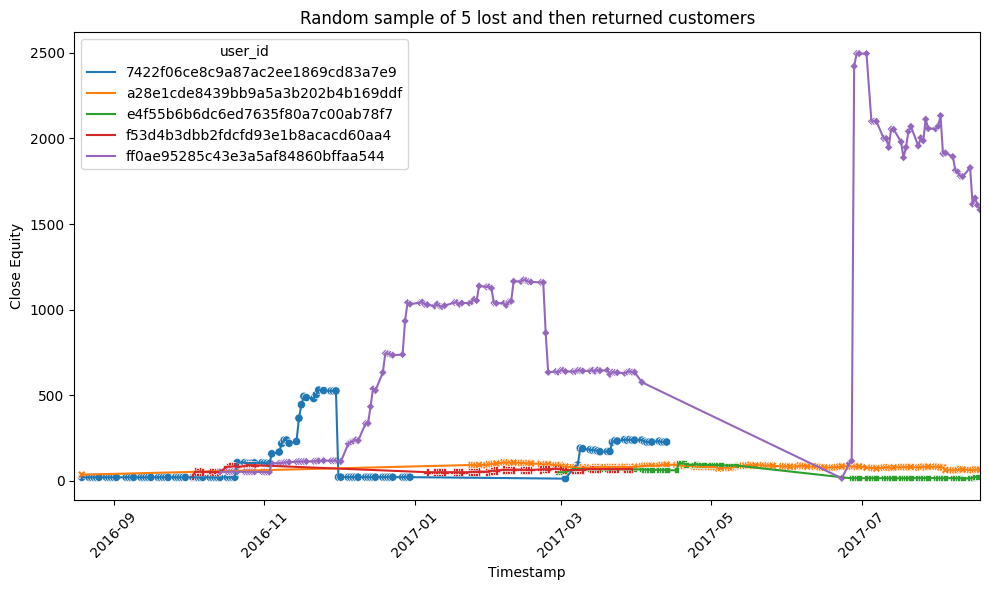

In [861]:
random_5_churned_returned = churned_returned['user_id'].drop_duplicates().sample(5)

filtered_df = churned_returned[churned_returned['user_id'].isin(random_5_churned_returned)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='timestamp', y='close_equity', hue='user_id')
sns.scatterplot(data=filtered_df, x='timestamp', y='close_equity', hue='user_id', style='user_id', legend=False)
plt.title('Random sample of 5 lost and then returned customers')
plt.xlabel('Timestamp')
plt.ylabel('Close Equity')
plt.xticks(rotation=45)
plt.xlim(evd_df['timestamp'].min(), evd_df['timestamp'].max())
plt.tight_layout()
plt.show()

In [862]:
# Find users who leave and don't come back
last_date = pd.DataFrame(evd_df.groupby('user_id')['timestamp'].max())
cut_off = evd_df['timestamp'].max() - pd.Timedelta(days= 28)
lost_users = last_date[last_date['timestamp'] < cut_off]

In [863]:
lost_users = lost_users.reset_index()

In [864]:
print(lost_users.columns)


Index(['user_id', 'timestamp'], dtype='object')


In [865]:
lost_users_df = pd.DataFrame({'user_id':lost_users['user_id'].unique()})
lost_users_df.head()

,user_id
0,004aab1640f3a04b87b1f404fb4c018d
1,004ea9d7662aa8dc840bbff212cfa4b8
2,00f89f56f25989b0bb7ea05bac2dccc4
3,01ef51aa8fab66b13d2249bc6ee68975
4,02012c83f5c4508404312aec848e2deb


In [866]:
evd_lost = evd_df[evd_df['user_id'].isin(lost_users_df['user_id'])]

In [867]:
evd_lost = evd_lost.sort_values(['user_id','timestamp'])

## Visualise lost cost customers sample

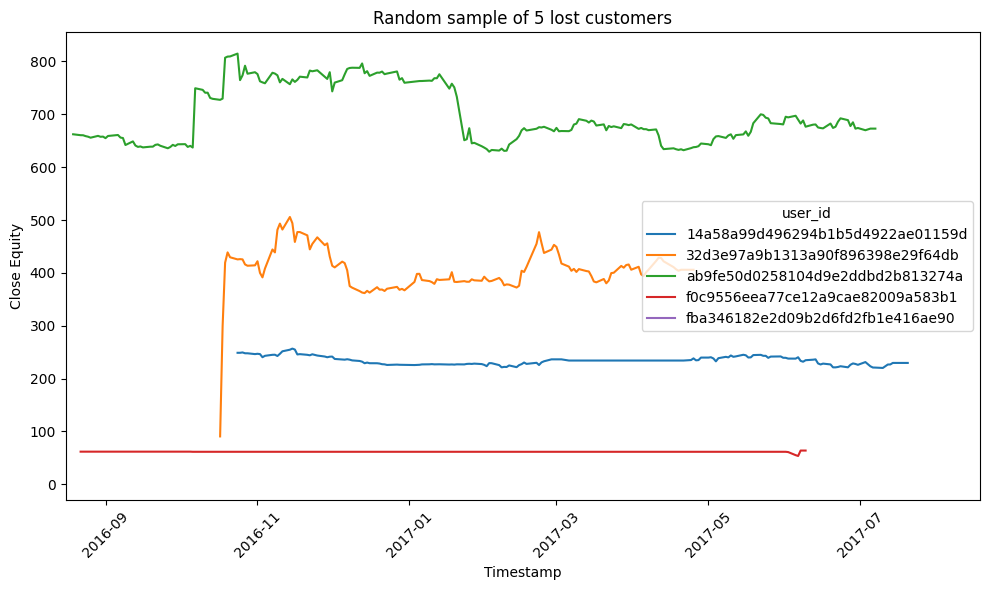

In [868]:
random_5_lost = evd_lost['user_id'].drop_duplicates().sample(5)

filtered_df = evd_lost[evd_lost['user_id'].isin(random_5_lost)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='timestamp', y='close_equity', hue='user_id')
plt.title('Random sample of 5 lost customers')
plt.xlabel('Timestamp')
plt.ylabel('Close Equity')
plt.xticks(rotation=45)
plt.xlim(evd_df['timestamp'].min(), evd_df['timestamp'].max())
plt.tight_layout()
plt.show()

In [869]:
all_churned = pd.concat([churned_returned_df,lost_users_df])

In [870]:
all_churned = pd.DataFrame({'user_id': all_churned['user_id'].unique()})
all_churned.shape[0]


1000

a) What percentage of users have churned in the data provided? [4 points]

ANSWER: Total number of users = 5584, total number churned = 1000, 1000/5584 = 0.18 = 18%

## EDA and feature engineering

In [871]:
# Add target variable ('churned') to feature dataset
df['churned'] = np.where(df['user_id'].isin(all_churned['user_id']), 1, 0)

In [872]:
df['churned'].sum()

1000

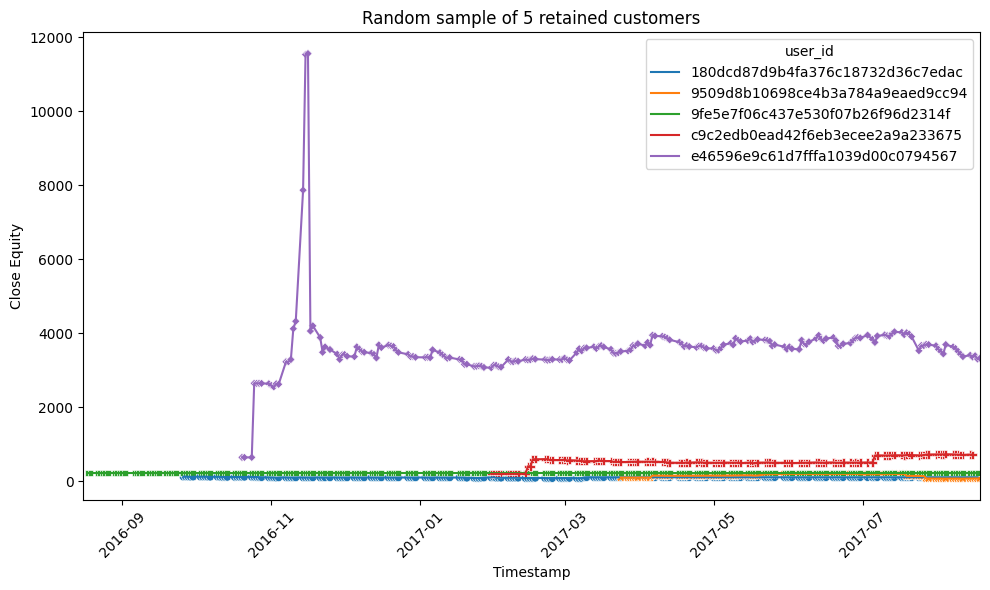

In [873]:
df_retained = df[df['churned'] == 0]
random_5_retained = df_retained ['user_id'].drop_duplicates().sample(5)

filtered_df = evd_df[evd_df['user_id'].isin(random_5_retained)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='timestamp', y='close_equity', hue='user_id')
sns.scatterplot(data=filtered_df, x='timestamp', y='close_equity', hue='user_id', style='user_id', legend=False)
plt.title('Random sample of 5 retained customers')
plt.xlabel('Timestamp')
plt.ylabel('Close Equity')
plt.xticks(rotation=45)
plt.xlim(evd_df['timestamp'].min(), evd_df['timestamp'].max())
plt.tight_layout()
plt.show()

In [874]:
df.isna().sum()

risk_tolerance                  0
investment_experience           0
liquidity_needs                 0
platform                        0
time_spent                      0
instrument_type_first_traded    0
first_deposit_amount            0
time_horizon                    0
user_id                         0
churned                         0
dtype: int64

In [875]:
df.duplicated().sum()

0

In [876]:
df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churned
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0


In [877]:
df.risk_tolerance.value_counts()

risk_tolerance
high_risk_tolerance    3566
med_risk_tolerance     1779
low_risk_tolerance      239
Name: count, dtype: int64

In [878]:
df['risk_tolerance_enc'] = df['risk_tolerance'].map({'low_risk_tolerance': 0,
    'med_risk_tolerance': 1,
    'high_risk_tolerance': 2})
df['risk_tolerance_enc'].value_counts()

risk_tolerance_enc
2    3566
1    1779
0     239
Name: count, dtype: int64

In [879]:
df.investment_experience.value_counts()

investment_experience
limited_investment_exp      2578
no_investment_exp           1796
good_investment_exp         1134
extensive_investment_exp      76
Name: count, dtype: int64

In [880]:
df['investment_experience_enc'] = df['investment_experience'].map({'no_investment_exp':0,
                                                                   'limited_investment_exp':1,
                                                                   'good_investment_exp':2,
                                                                   'extensive_investment_exp':3})
df['investment_experience_enc'].value_counts()

investment_experience_enc
1    2578
0    1796
2    1134
3      76
Name: count, dtype: int64

In [881]:
df.value_counts()

risk_tolerance       investment_experience     liquidity_needs              platform  time_spent  instrument_type_first_traded  first_deposit_amount  time_horizon        user_id                           churned  risk_tolerance_enc  investment_experience_enc
high_risk_tolerance  extensive_investment_exp  not_important_liq_need       Android   8.699233    stock                         20.0                  long_time_horizon   bb6b604790ae957a3dcc3851ac5a1d48  0        2                   3                            1
low_risk_tolerance   no_investment_exp         somewhat_important_liq_need  iOS       9.539900    stock                         50.0                  med_time_horizon    d7af15a379bf121ece5d3024baab84a9  1        0                   0                            1
                                                                                      28.280283   stock                         20.0                  short_time_horizon  23994d84edc783a3379830b5f242f3d7  1        

In [882]:
df['liquidity_needs_enc'] = df['liquidity_needs'].map({'not_important_liq_need':0,
                                                       'somewhat_important_liq_need':1,
                                                       'very_important_liq_need':2})

In [883]:
df.platform.value_counts()
# not an ordinal category, unlikely to be revelant (but one-hot encode in case)
df = pd.get_dummies(df, columns = ['platform'], prefix = 'platform', dtype = int)
df.head()


,risk_tolerance,investment_experience,liquidity_needs,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churned,risk_tolerance_enc,investment_experience_enc,liquidity_needs_enc,platform_Android,platform_both,platform_iOS
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0,2,1,2,1,0,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0,1,1,2,1,0,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0,1,1,2,0,0,1
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0,1,1,2,1,0,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0,2,1,2,1,0,0


In [884]:
df.instrument_type_first_traded.value_counts()



instrument_type_first_traded
stock       4827
etp          383
adr          197
mlp           55
reit          55
cef           20
wrt           16
0             13
rlt            9
lp             8
tracking       1
Name: count, dtype: int64

In [885]:
df['stock_instrument_type_first_traded_enc'] = np.where(df['instrument_type_first_traded'] == 'stock',1,0) # 0 here refers to everything else that's not stock
df['stock_instrument_type_first_traded_enc'].value_counts()

stock_instrument_type_first_traded_enc
1    4827
0     757
Name: count, dtype: int64

In [886]:
df.time_horizon.value_counts()

time_horizon
short_time_horizon    2833
long_time_horizon     1833
med_time_horizon       918
Name: count, dtype: int64

In [887]:
df['time_horizon_enc'] = df['time_horizon'].map({'short_time_horizon':0,
                                                 'med_time_horizon': 1,
                                                 'long_time_horizon':2})
df['time_horizon_enc'].value_counts()

time_horizon_enc
0    2833
2    1833
1     918
Name: count, dtype: int64

can also generate subset of the data on the 'more solid' looking lost users

In [888]:
df['is_lost_user'] = np.where(df['user_id'].isin(lost_users['user_id']), 1, 0)


Drop old columns and target variable

In [889]:
y = df['churned'] # can try is_lost_user for smaller subset of users who leave and don't come back
X = df.drop(['risk_tolerance','investment_experience','liquidity_needs','instrument_type_first_traded','time_horizon','user_id','churned','is_lost_user'], axis = 1)
X.head()

,time_spent,first_deposit_amount,risk_tolerance_enc,investment_experience_enc,liquidity_needs_enc,platform_Android,platform_both,platform_iOS,stock_instrument_type_first_traded_enc,time_horizon_enc
0,33.129417,40.0,2,1,2,1,0,0,1,1
1,16.573517,200.0,1,1,2,1,0,0,1,0
2,10.008367,25.0,1,1,2,0,0,1,1,2
3,1.031633,100.0,1,1,2,1,0,0,1,0
4,8.187250,20.0,2,1,2,1,0,0,1,2


In [890]:
print(X.shape, y.shape)


(5584, 10) (5584,)


Split the data into train and test splits: data is imbalanced (18% churned), so stratfiy the split so equal outcomes are in the split

In [891]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

## Scale the data

In [892]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train a logistic regression classifier

In [893]:
#initialise the model
lgr_clf = LogisticRegression(class_weight='balanced')
# train the model
lgr_clf.fit(X_train_scaled, y_train)

# make predictions on output category
y_train_pred = lgr_clf.predict(X_train_scaled)
y_test_pred = lgr_clf.predict(X_test_scaled)

# make predicted probabilities 
y_train_pred_proba = lgr_clf.predict_proba(X_train_scaled)
y_test_pred_proba = lgr_clf.predict_proba(X_test_scaled)

# evaluate model performance
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
precision_test = precision_score(y_test, y_test_pred) 
recall_train = recall_score(y_train,y_train_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

#print eval metrics
print(f'Train accuracy score: {accuracy_train:.2f}')
print(f'Test accuracy score: {accuracy_test:.2f}')


print(f'Train precision score: {precision_train:.2f}')
print(f'Test precision score: {precision_test:.2f}')

print(f'Train recall score: {recall_train:.2f}')
print(f'Test recall score: {recall_test:.2f}')

print(f'Train f1 score: {f1_train:.2f}')
print(f'Test f1 score: {f1_test:.2f}')

print(f'Train ROC_AUC score: {roc_auc_train:.2f}')
print(f'Test ROC_AUC score: {roc_auc_test:.2f}')



Train accuracy score: 0.61
Test accuracy score: 0.61
Train precision score: 0.25
Test precision score: 0.24
Train recall score: 0.59
Test recall score: 0.58
Train f1 score: 0.35
Test f1 score: 0.34
Train ROC_AUC score: 0.60
Test ROC_AUC score: 0.59


Model is performing not much better than random...

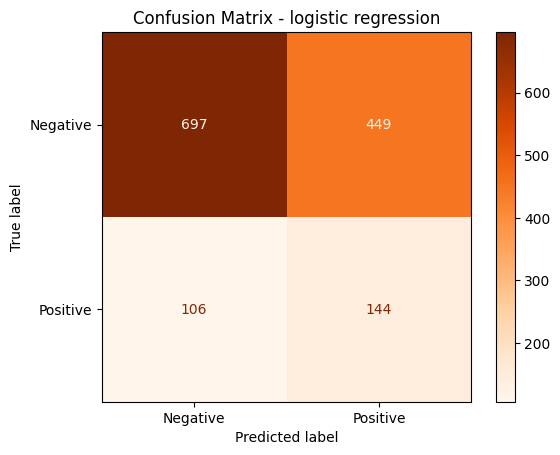

In [894]:
# look at confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Negative", "Positive"])
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix - logistic regression")
plt.show()


In [895]:
# Define the parameter grid
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],              
    'solver': ['liblinear', 'saga'],      
    'class_weight': [None, 'balanced']    
}

# Initialize the logistic regression model
log_reg = LogisticRegression(random_state=42)

# Use F1 score as the evaluation metric
scorer = make_scorer(f1_score)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=scorer,  
    cv=5,            
    verbose=1,       
    n_jobs=-1        
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score found: ", grid_search.best_score_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best parameters found:  {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 score found:  0.3446137525095176


*b) Build a classifier that, given a user with their features, assigns a churn probability for every user and predicts which users will churn. How well does your classifier perform? State any metrics you deem important here. Based on the classifier output, classify each user in the dataset as churned or not churned. [5 points]*

My classifier is performing quite badly! Not much better than random (ROC_AUC on the test data is 0.59)...

In [896]:
# Get the coefficients
coefficients = lgr_clf.coef_[0]
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefficients
})

feature_importance['absolute_coefficient'] = feature_importance['coefficient'].abs() # Sort by absolute value of coefficients
feature_importance = feature_importance.sort_values(by='absolute_coefficient', ascending=False)

print(feature_importance)

                                  feature  coefficient  absolute_coefficient
1                    first_deposit_amount    -0.483013              0.483013
2                      risk_tolerance_enc    -0.280475              0.280475
4                     liquidity_needs_enc    -0.133133              0.133133
9                        time_horizon_enc    -0.095461              0.095461
0                              time_spent     0.072216              0.072216
5                        platform_Android     0.058631              0.058631
8  stock_instrument_type_first_traded_enc     0.053230              0.053230
7                            platform_iOS    -0.040132              0.040132
6                           platform_both    -0.024649              0.024649
3               investment_experience_enc    -0.019937              0.019937


In [897]:
# Try XGBoost, lightGBM, CatBoost
# Calculate scale_pos_weight for imbalanced dataset for XGBoost model
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# define model names for loop
models = {'xgboost':XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
          'lgbm':LGBMClassifier(class_weight = 'balanced', verbose = -1, random_state = 42),
          'catboost': CatBoostClassifier(class_weights =[1,scale_pos_weight], verbose = 0, random_state = 42),
          'hgb': HistGradientBoostingClassifier(class_weight = 'balanced', random_state = 42)} 

results = {}

# train models
for model_name, model in models.items():
    # fit the models
    model.fit(X_train, y_train)

    # make predictions on training and test data, to check overfitting
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # gather eval metrics
    train_F1 = f1_score(y_train, y_train_pred)
    test_F1 = f1_score(y_test, y_test_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
  


    #put these eval results into results dictionary
    results[model_name] = {'train_F1':train_F1,
                           'test_F1':test_F1,
                           'train_recall':train_recall,
                           'test_recall':test_recall,
                           'train_precision':train_precision,
                           'test_precision':test_precision,
                           'train_accuracy':train_accuracy,
                           'test_accuracy':test_accuracy,
                           'train_roc_auc':roc_auc_train,
                           'test_roc_auc':roc_auc_test}
                          
    
    #convert dict into df to enable visualisation and comparison of the results
    eval_results = pd.DataFrame(results).T

In [898]:
    eval_results

,train_F1,test_F1,train_recall,test_recall,train_precision,test_precision,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
xgboost,0.819747,0.275387,0.952000,0.320,0.719758,0.241692,0.925024,0.698424,0.935570,0.550489
lgbm,0.629718,0.299572,0.878667,0.420,0.490692,0.232816,0.814947,0.648281,0.839857,0.559040
catboost,0.587018,0.306818,0.832000,0.432,0.453488,0.237885,0.790353,0.650430,0.806634,0.565040
hgb,0.635755,0.286558,0.886667,0.388,0.495529,0.227166,0.818052,0.654011,0.844875,0.550021
